# Accuracy

Hold out some of the training and use it to test the predictions.

### Imports

In [262]:
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp

np.set_printoptions(precision=2, floatmode='fixed', suppress=True, threshold=10, edgeitems=10)

### Real world points

In [263]:
# open cv world coords: x right, y down, z forward.
# distance 5 m side to side
x_space_cv = np.linspace(-5, 5, 41)
# y is down, and zero is at the floor
y_space_cv = np.linspace(-0.5, -1.5, 5)
# distance from 0.5 to 5 meters
z_space_cv = np.linspace(0.25, 5, 20)
X_cv, Y_cv, Z_cv = np.meshgrid(x_space_cv, y_space_cv, z_space_cv)
X_cv = X_cv.reshape(1, -1).T
Y_cv = Y_cv.reshape(1, -1).T
Z_cv = Z_cv.reshape(1, -1).T

### Camera intrinsics and pose

In [264]:
# intrinsic matrix
K = np.array([[300.0, 0.0, 250.0], [0.0, 300.0, 250.0], [0.0, 0.0, 1.0]])

# distortion coefficients (k1, k2, p1, p2, k3)
# A LOT of distortion, in order to see it work.
distCoeffs = np.array([1.5, -0.95, -0.005, 0.0025, 1.16])
# distCoeffs = np.array([0.0, 0.0, 0.0, 0.0, 0.0])

# world in camera coordinates: camera up means world down.
rvec = np.array([-0.4, 0.0, 0.0])
# camera is 0.5m up (negative) from the floor, which means world is 0.5m down (positive)
tvec = np.array([0.0, 0.2, 0.0])

### Project points to pixels, (u, v)

For each tag height, the points look like a "ceiling" above the camera

before masking
[[-1.08e+10 -3.53e+08  7.47e+09  5.00e-01  2.50e-01  5.00e+00]
 [-5.17e+08 -6.81e+06  2.81e+08  5.00e-01  5.00e-01  5.00e+00]
 [-6.21e+07  3.92e+05  2.78e+07  5.00e-01  7.50e-01  5.00e+00]
 [-1.22e+07  3.14e+05  4.65e+06  5.00e-01  1.00e+00  5.00e+00]
 [-3.24e+06  1.47e+05  1.09e+06  5.00e-01  1.25e+00  5.00e+00]
 [-1.06e+06  6.89e+04  3.20e+05  5.00e-01  1.50e+00  5.00e+00]
 [-4.05e+05  3.44e+04  1.12e+05  5.00e-01  1.75e+00  5.00e+00]
 [-1.74e+05  1.83e+04  4.44e+04  5.00e-01  2.00e+00  5.00e+00]
 [-8.24e+04  1.04e+04  1.96e+04  5.00e-01  2.25e+00  5.00e+00]
 [-4.21e+04  6.29e+03  9.46e+03  5.00e-01  2.50e+00  5.00e+00]
 ...
 [ 9.09e+03  5.05e+01  1.27e+03  1.50e+00  2.75e+00 -5.00e+00]
 [ 5.86e+03  2.32e+02  7.41e+02  1.50e+00  3.00e+00 -5.00e+00]
 [ 4.01e+03  3.10e+02  4.56e+02  1.50e+00  3.25e+00 -5.00e+00]
 [ 2.90e+03  3.44e+02  2.95e+02  1.50e+00  3.50e+00 -5.00e+00]
 [ 2.21e+03  3.57e+02  1.99e+02  1.50e+00  3.75e+00 -5.00e+00]
 [ 1.77e+03  3.62e+02  1.41e+02  1.

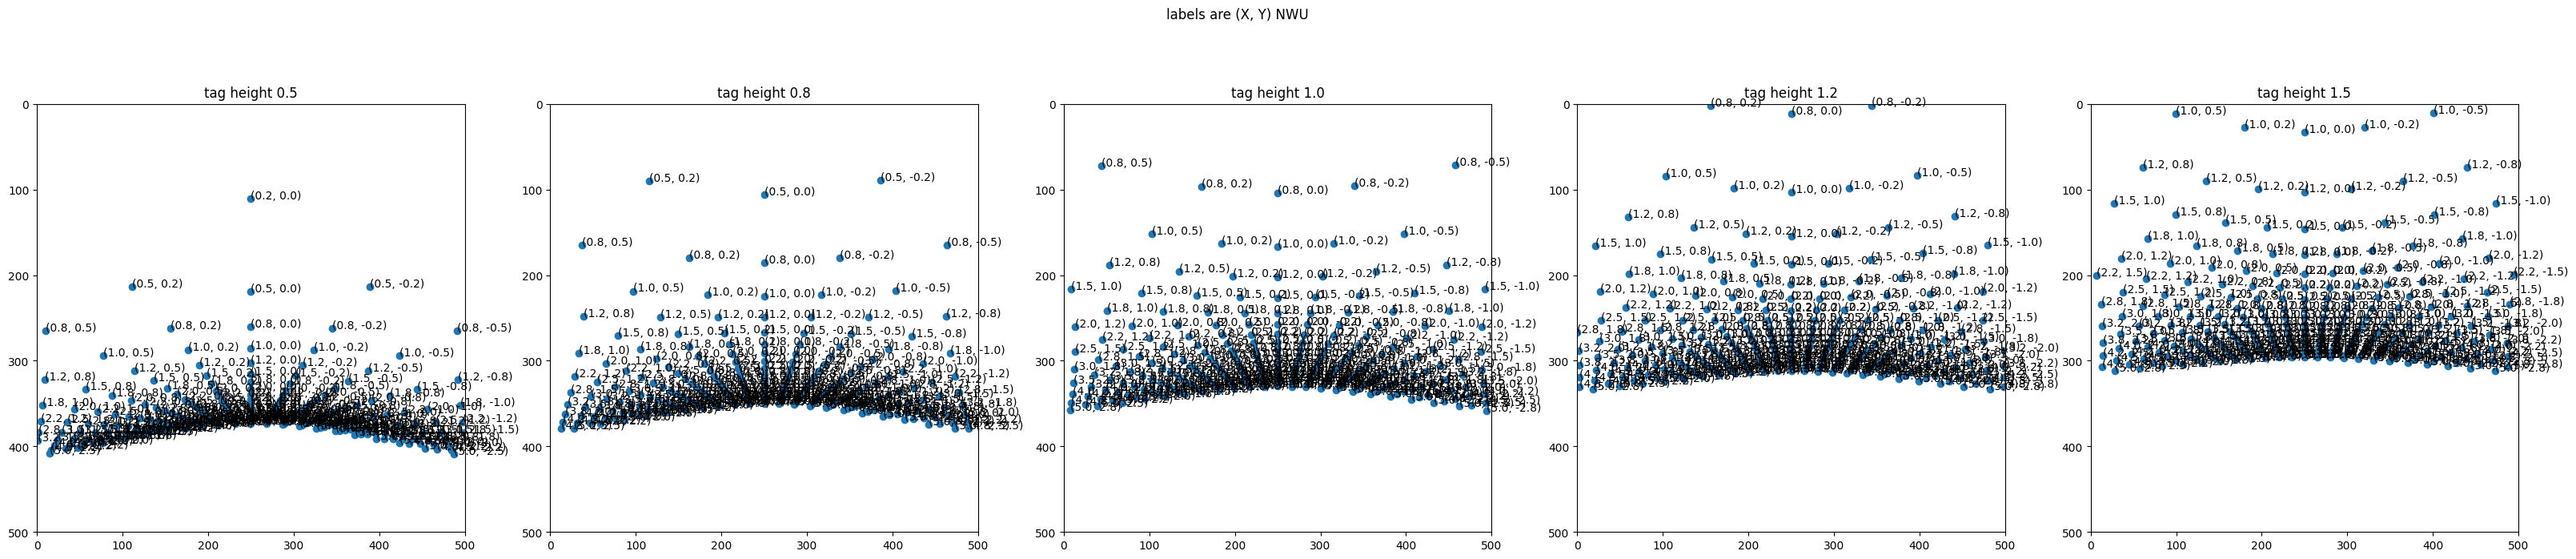

In [265]:
# these are the tag centers
XYZ_cv = np.hstack((X_cv, Y_cv, Z_cv))
# print(XYZ_cv)
U_dist, _ = cv2.projectPoints(XYZ_cv, rvec, tvec, K, distCoeffs)
# (u, v) are pixels
uv = U_dist[:, 0]

# for the purpose of this simulation let's just make another point 0.2m above the center
XYZ_cv[:,1] -= 0.2
# print(XYZ_cv)
U_dist2, _ = cv2.projectPoints(XYZ_cv, rvec, tvec, K, distCoeffs)
uv2 = U_dist2[:, 0]
# print(uv)
# print(uv2)
dd = uv - uv2
d = np.hypot(dd[:,0],dd[:,1])
d = d.reshape(1, -1).T
# print(d)


X_nwu = Z_cv  # ahead
Y_nwu = -X_cv  # left
# print(Y_nwu)
Z_nwu = -Y_cv  # up

# this is the training data
uvdZXY_nwu = np.hstack((uv, d, Z_nwu, X_nwu, Y_nwu))
print("before masking")
print(uvdZXY_nwu)
uvdZXY_nwu = uvdZXY_nwu[
    (uvdZXY_nwu[:, 0] >= 0)
    & (uvdZXY_nwu[:, 1] >= 0)
    & (uvdZXY_nwu[:, 0] <= 500)
    & (uvdZXY_nwu[:, 1] <= 500)
]
print("masked")
print(uvdZXY_nwu)

fig, ax = plt.subplots(1, y_space_cv.size, figsize=(40, 8))
fig.suptitle("labels are (X, Y) NWU")

for i, tag_height in enumerate(y_space_cv):
    truth_for_height = uvdZXY_nwu[np.isclose(uvdZXY_nwu[:, 3], -tag_height)]
    print(truth_for_height)
    uuu = truth_for_height.T[0]
    vvv = truth_for_height.T[1]
    ax[i].scatter(uuu, vvv)
    ax[i].set_title(f"tag height {-tag_height:.1f}")
    ax[i].set_aspect("equal")
    ax[i].set_xlim(0, 500)
    ax[i].set_ylim(0, 500)
    ax[i].invert_yaxis()  # camera y is positive-down
    for ii, row in enumerate(truth_for_height):
        ax[i].annotate(f"({0.0+row[4]:.1f}, {0.0+row[5]:.1f})", (row[0], row[1]))

plt.show()

### Predict XY from simulated uvdZ and measure the accuracy of the prediction.

Notice that the linear interpolator fails a substantial amount, due to its restriction on the domain: it can only interpolate within the convex hull of the training data.  The RBF interpolator never does this.

The RBF interpolator shows generally lower MAE, but often very bad errors for up-close targets where the training is sparse.

-2.75
2.75
[5.00 4.50 4.75 4.50 4.75 3.25 3.50 3.75 4.00 4.25 ... 3.00 3.25 3.50 4.00
 3.50 3.75 4.00 4.75 4.25 5.00]
[ 2.50  2.25  2.25  2.00  2.00  1.75  1.75  1.75  1.75  1.75 ... -1.50
 -1.50 -1.50 -1.50 -2.00 -2.00 -2.00 -2.00 -2.50 -2.50]
-2.75
2.5


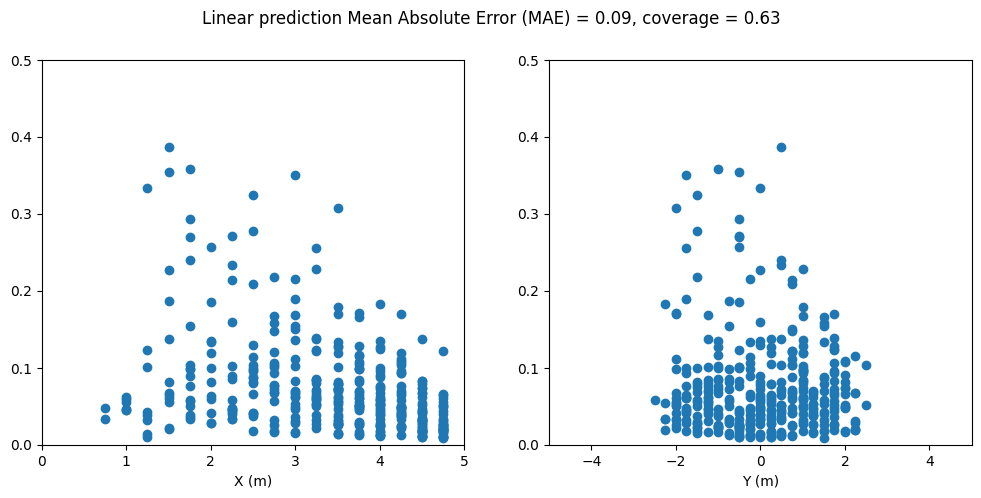

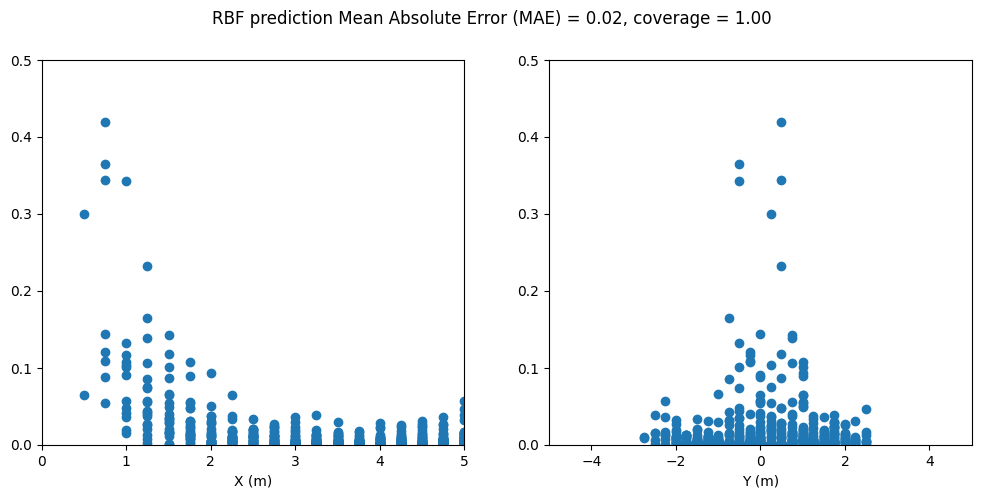

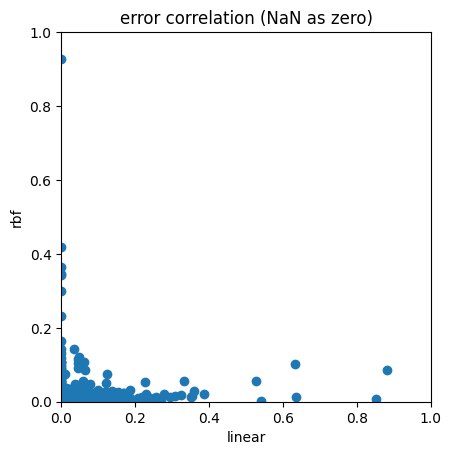

In [266]:
# split the training into train and eval.

print(np.min(uvdZXY_nwu[:,5]))
print(np.max(uvdZXY_nwu[:,5]))

rows = uvdZXY_nwu.shape[0]
discriminator = np.random.rand(rows)
uvdZXY_nwu_train = uvdZXY_nwu[discriminator < 0.50]
uvdZXY_nwu_test = uvdZXY_nwu[discriminator >= 0.50]
print(uvdZXY_nwu_test[:,4])
print(uvdZXY_nwu_test[:,5])

print(np.min(uvdZXY_nwu_test[:,5]))
print(np.max(uvdZXY_nwu_test[:,5]))


# thin_plate_spline and linear perform poorly
# cubic delivers MAE around 0.1
# quintic delivers MAE around 0.05 
uvdZ_nwu_to_XY_nwu_rbf = interp.RBFInterpolator(
    uvdZXY_nwu_train[:, (0, 1, 2, 3)], uvdZXY_nwu_train[:, (4, 5)], kernel="quintic"
)

uvdZ_nwu_to_XY_nwu_linear = interp.LinearNDInterpolator(
    uvdZXY_nwu_train[:, (0, 1, 2, 3)], uvdZXY_nwu_train[:, (4, 5)]
)

predictedXY_nwu_rbf = uvdZ_nwu_to_XY_nwu_rbf(uvdZXY_nwu_test[:, (0, 1, 2, 3)])

predictedXY_nwu_linear = uvdZ_nwu_to_XY_nwu_linear(uvdZXY_nwu_test[:, (0, 1, 2, 3)])

errXY_rbf = predictedXY_nwu_rbf - uvdZXY_nwu_test[:, (4, 5)]
errXY_linear = predictedXY_nwu_linear - uvdZXY_nwu_test[:, (4, 5)]

# print(errXY_rbf)
# print(errXY_linear)
nan_count_rbf = np.count_nonzero(np.isnan(errXY_rbf[:,0]))
nan_count_linear = np.count_nonzero(np.isnan(errXY_linear[:,0]))

coverage_rbf = 1 - nan_count_rbf / uvdZXY_nwu_test.shape[0]
coverage_linear = 1 - nan_count_linear / uvdZXY_nwu_test.shape[0]

err_hypot_rbf = np.hypot(errXY_rbf[:, 0], errXY_rbf[:, 1])
err_hypot_linear = np.hypot(errXY_linear[:, 0], errXY_linear[:, 1])
# xmax = np.nanmax((err_hypot_rbf, err_hypot_linear))
xmax = 0.5

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f"Linear prediction Mean Absolute Error (MAE) = {np.nanmean(err_hypot_linear):.2f}, coverage = {coverage_linear:.2f}")

ax[0].scatter(uvdZXY_nwu_test[:, 4], err_hypot_linear)
ax[0].set_xlim(0,5)
ax[0].set_ylim((0, xmax))
ax[0].set_xlabel("X (m)")

ax[1].scatter(uvdZXY_nwu_test[:, 5], err_hypot_linear)
ax[1].set_xlim(-5,5)
ax[1].set_ylim((0, xmax))
ax[1].set_xlabel("Y (m)")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f"RBF prediction Mean Absolute Error (MAE) = {np.nanmean(err_hypot_rbf):.2f}, coverage = {coverage_rbf:.2f}")

ax[0].scatter(uvdZXY_nwu_test[:, 4], err_hypot_rbf)
ax[0].set_xlim(0,5)
ax[0].set_ylim((0, xmax))
ax[0].set_xlabel("X (m)")

ax[1].scatter(uvdZXY_nwu_test[:, 5], err_hypot_rbf)
ax[1].set_xlim(-5,5)
ax[1].set_ylim((0, xmax))
ax[1].set_xlabel("Y (m)")

plt.show()

plt.scatter(np.nan_to_num(err_hypot_linear), np.nan_to_num(err_hypot_rbf))
plt.title("error correlation (NaN as zero)")
plt.xlabel("linear")
plt.ylabel("rbf")
plt.xlim((0,1))
plt.ylim((0,1))
plt.gca().set_aspect("equal")
plt.show()

